In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functions.stats import *

from sklearn.metrics import roc_curve

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

### Importar previsões

In [16]:
morgan_padel = pd.read_excel('predictions/predictions-morgan-padel.xlsx', sheet_name='morgan-padel')
morgan_padel.rename(columns={'Prediction': 'morgan', 'AD': "morgan_ad"}, inplace=True)
morgan_padel.head(1)

,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,SMILES,morgan,morgan_ad,padel,padel_ad,consensus,consensus_ad,consensus_rigor
0,NaN,IC50,0,5700.0,nM,1,AEYIBAPLFDNVGD-UHFFFAOYNA-N,NaN,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,1,1.0,1,NaN,1,1.0,NaN


In [17]:
sirms_dragon = pd.read_excel('predictions/predictions-sirms-dragon.xlsx', sheet_name='sirms-dragon')
sirms_dragon.head(1)

,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,SMILES,sirms,sirms_ad,dragon,dragon_ad,consensus,consensus_ad,consensus_rigor
0,NaN,IC50,0,5700.0,nM,1,AEYIBAPLFDNVGD-UHFFFAOYNA-N,NaN,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,1,1.0,1,1.0,1,1.0,1.0


In [18]:
sirms_dragon = sirms_dragon[['Compound_name', 'Molecule ChEMBL ID', 'Outcome', 'SMILES', 'InChIKey', 'sirms', 'sirms_ad', 'dragon', 'dragon_ad']]
morgan_padel = morgan_padel[['Compound_name', 'Molecule ChEMBL ID', 'Outcome', 'SMILES', 'InChIKey', 'morgan', 'morgan_ad', 'padel', 'padel_ad']]
predictions = pd.merge(sirms_dragon, morgan_padel[['InChIKey', 'morgan', 'morgan_ad', 'padel', 'padel_ad']] , on='InChIKey')
predictions.head()

,Compound_name,Molecule ChEMBL ID,Outcome,SMILES,InChIKey,sirms,sirms_ad,dragon,dragon_ad,morgan,morgan_ad,padel,padel_ad
0,NaN,NaN,1,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,AEYIBAPLFDNVGD-UHFFFAOYNA-N,1,1.0,1,1.0,1,1.0,1,NaN
1,(2R)-2-(4-acetamido-N-[2-(benzotriazol-1-yl)ac...,NaN,1,CCC(C)(C)NC(=O)C(c1cccn1C)N(C(=O)Cn1nnc2ccccc2...,BCIIGGMNYNWRQK-UHFFFAOYSA-N,0,NaN,0,NaN,0,NaN,0,NaN
2,NaN,NaN,0,Cc1cc(C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C(=O)NC...,BEDKZMYJXHXMQM-OPEKNORGSA-N,0,NaN,1,NaN,0,NaN,1,NaN
3,(2S)-N-[(2S)-1-hydroxy-3-phenylpropan-2-yl]-3-...,NaN,1,O=C(C=Cc1ccccc1)NC(Cc1ccccc1)C(=O)NC(CO)Cc1ccccc1,GEVQDXBVGFGWFA-UHFFFAOYSA-N,1,NaN,1,NaN,0,0.0,0,NaN
4,NaN,NaN,0,CC(=O)NC(CC(=O)O)C(=O)NC(CO)C(=O)NC(Cc1ccccc1)...,HYACKLDVAOZFRF-UHFFFAOYSA-N,1,1.0,1,NaN,0,NaN,0,NaN


In [19]:
for col in predictions.columns:
    predictions[col].replace('Inactive',0,inplace=True)
    predictions[col].replace('Active',1,inplace=True)

### Consenso

In [20]:
# consenso
predictions['consenso'] = (predictions.sirms + predictions.dragon + predictions.morgan + predictions.padel)/4
predictions['consenso'] = np.where(predictions['consenso'] > 0.5, 1, 0)

In [21]:
# Consenso AD
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consenso_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i] + predictions.morgan_ad[i] + predictions.padel_ad[i])/4
        predictions.loc[i,'consenso_ad'] = np.where(predictions.loc[i,'consenso_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consenso_ad'] = (predictions.dragon_ad[i] + predictions.morgan_ad[i] + predictions.padel_ad[i])/3
        predictions.loc[i,'consenso_ad'] = np.where(predictions.loc[i,'consenso_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consenso_ad'] = (predictions.sirms_ad[i] + predictions.morgan_ad[i] + predictions.padel_ad[i])/3
        predictions.loc[i,'consenso_ad'] = np.where(predictions.loc[i,'consenso_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consenso_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i] + predictions.padel_ad[i])/3
        predictions.loc[i,'consenso_ad'] = np.where(predictions.loc[i,'consenso_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == True]):
        predictions.loc[i,'consenso_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i] + predictions.morgan_ad[i])/3
        predictions.loc[i,'consenso_ad'] = np.where(predictions.loc[i,'consenso_ad'] > 0.5, 1, 0)        
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == True, np.isnan(predictions.padel_ad[i]) == True]):
        predictions.loc[i,'consenso_ad'] = predictions.sirms_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True, np.isnan(predictions.padel_ad[i]) == True]):
        predictions.loc[i,'consenso_ad'] = predictions.dragon_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == True]):
        predictions.loc[i,'consenso_ad'] = predictions.morgan_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == True, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consenso_ad'] = predictions.padel_ad[i]        
    else:
        predictions.loc[i,'consenso_ad']  = np.nan

### Calcular estatísticas

In [22]:
# estatísticas morgan
morgan = pd.DataFrame(stats(predictions['Outcome'], predictions['morgan'])).round(2)
morgan['Cobertura'] = 1.0

# estatísticas morgan AD
morgan_ad = predictions.dropna(subset=['morgan_ad'])
coverage_morgan_ad = len(morgan_ad['morgan_ad']) / len(predictions['Outcome'])
morgan_ad = pd.DataFrame(stats(morgan_ad['Outcome'], morgan_ad['morgan_ad'])).round(2)
morgan_ad['Cobertura'] = round(coverage_morgan_ad, 2)

# imprimir estatísticas
morgan_5f_stats = morgan.append(morgan_ad)
morgan_5f_stats.set_index([['Morgan', 'Morgan AD']], drop=True, inplace=True)

# estatísticas sirms
sirms = pd.DataFrame(stats(predictions['Outcome'], predictions['sirms'])).round(2)
sirms['Cobertura'] = 1.0

# estatísticas sirms AD
sirms_ad = predictions.dropna(subset=['sirms_ad'])
coverage_sirms_ad = len(sirms_ad['sirms_ad']) / len(predictions['Outcome'])
sirms_ad = pd.DataFrame(stats(sirms_ad['Outcome'], sirms_ad['sirms_ad'])).round(2)
sirms_ad['Cobertura'] = round(coverage_sirms_ad, 2)

# imprimir estatísticas
sirms_5f_stats = sirms.append(sirms_ad)
sirms_5f_stats.set_index([['sirms', 'sirms AD']], drop=True, inplace=True)

# estatísticas dragon
dragon = pd.DataFrame(stats(predictions['Outcome'], predictions['dragon'])).round(2)
dragon['Cobertura'] = 1.0

# estatísticas dragon AD
dragon_ad = predictions.dropna(subset=['dragon_ad'])
coverage_dragon_ad = len(dragon_ad['dragon_ad']) / len(predictions['Outcome'])
dragon_ad = pd.DataFrame(stats(dragon_ad['Outcome'], dragon_ad['dragon_ad'])).round(2)
dragon_ad['Cobertura'] = round(coverage_dragon_ad, 2)

# imprimir estatísticas
dragon_5f_stats = dragon.append(dragon_ad)
dragon_5f_stats.set_index([['dragon', 'dragon AD']], drop=True, inplace=True)

# estatísticas padel
padel = pd.DataFrame(stats(predictions['Outcome'], predictions['padel'])).round(2)
padel['Cobertura'] = 1.0

# estatísticas padel AD
padel_ad = predictions.dropna(subset=['padel_ad'])
coverage_padel_ad = len(padel_ad['padel_ad']) / len(predictions['Outcome'])
padel_ad = pd.DataFrame(stats(padel_ad['Outcome'], padel_ad['padel_ad'])).round(2)
padel_ad['Cobertura'] = round(coverage_padel_ad, 2)

# imprimir estatísticas
padel_5f_stats = padel.append(padel_ad)
padel_5f_stats.set_index([['padel', 'padel AD']], drop=True, inplace=True)

# estatísticas de consenso
consenso = pd.DataFrame(stats(predictions['Outcome'], predictions['consenso'])).round(2)
consenso['Cobertura'] = 1.0

# estatísticas consenso AD
consenso_ad = predictions.dropna(subset=['consenso_ad'])
coverage_consenso_ad = len(consenso_ad['consenso_ad']) / len(predictions['Outcome'])
consenso_ad = pd.DataFrame(stats(consenso_ad['Outcome'], consenso_ad['consenso_ad'])).round(2)
consenso_ad['Cobertura'] = round(coverage_consenso_ad, 2)

# imprimir estatísticas
consenso_5f_stats = consenso.append(consenso_ad)
consenso_5f_stats.set_index([['consenso', 'consenso AD']], drop=True, inplace=True)

In [23]:
stats = pd.concat([morgan_ad, sirms_ad, dragon_ad, padel_ad, consenso, consenso_ad], axis=0)
stats.set_index([['Morgan', 'SiRMS', 'Dragon', 'Padel','' 'Consenso', 'Consenso (AD)']], drop=True, inplace=True)

stats

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Cobertura
Morgan,0.64,0.79,0.60,0.94,0.98,0.84,0.86,0.73,0.70
SiRMS,0.67,0.82,0.71,0.85,0.93,0.86,0.86,0.77,0.62
Dragon,0.62,0.78,0.61,0.85,0.96,0.87,0.86,0.71,0.58
Padel,0.62,0.79,0.62,0.80,0.96,0.90,0.88,0.70,0.51
Consenso,0.54,0.75,0.57,0.82,0.93,0.80,0.81,0.68,1.00
Consenso (AD),0.61,0.79,0.65,0.76,0.93,0.88,0.86,0.70,0.68


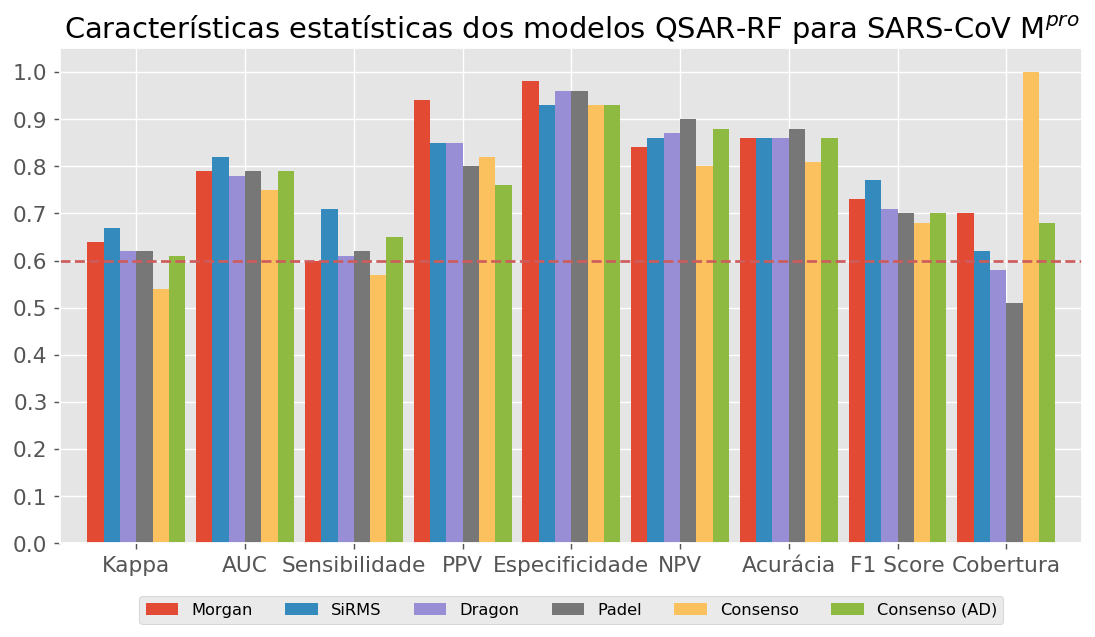

In [24]:
# Transpose stats
stats_t = stats.T
stats_t = stats_t.reset_index()
stats_t = stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(9,5), dpi=130)

stats_t.plot(kind='bar', ax=ax1, width=0.9)
ax1.set_xticklabels(labels=stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
plt.title('Características estatísticas dos modelos QSAR-RF para SARS-CoV M$^{pro}$', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=12)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=9,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=7)
fig.tight_layout()

plt.savefig('figures/statistics-qsar-models-RF.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();